In [1]:
import torch
import torch.nn as nn
import tiktoken

In this chapter we will implement the LLM archtiecture of GPT - 2

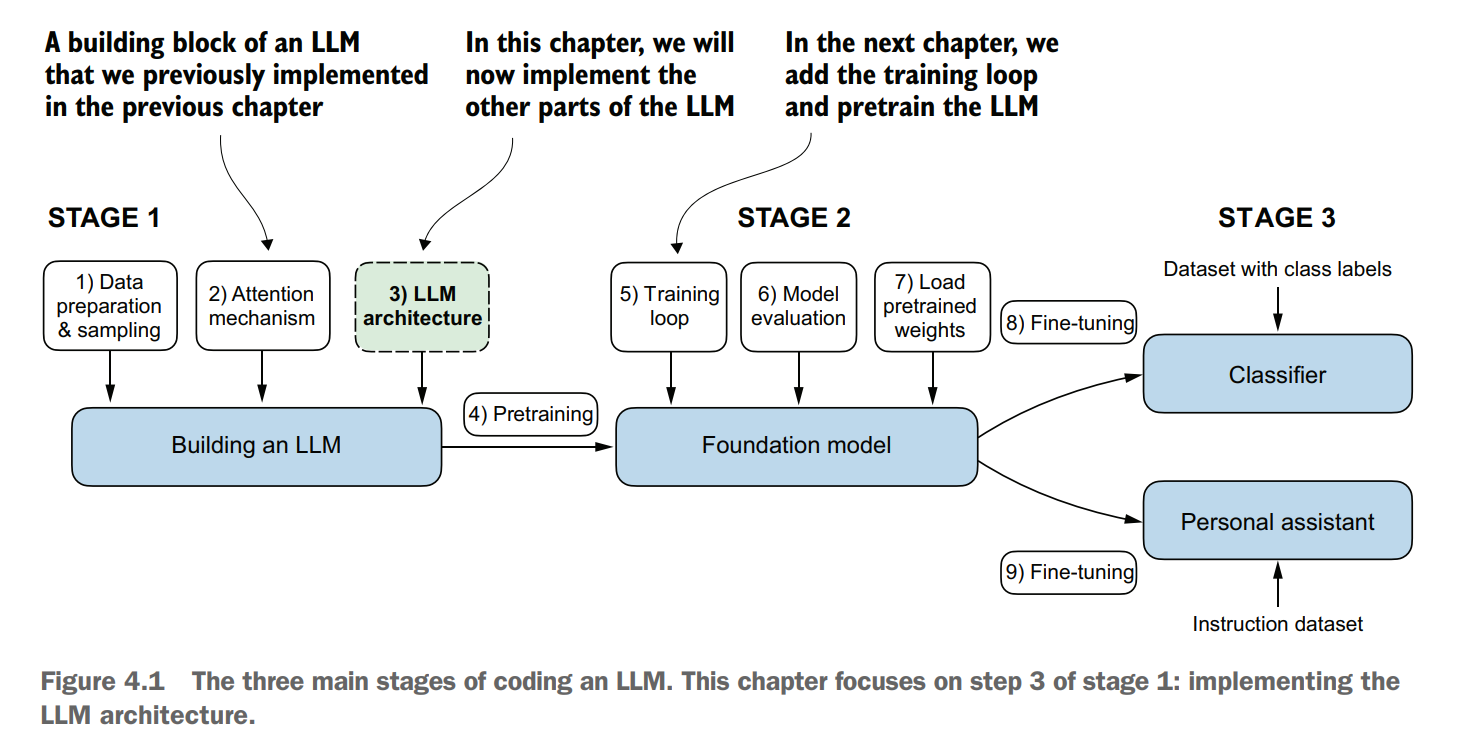

The following is a Bird's eye view of the GPT model that we will be implementing keeping the transformer and layer norm part as placeholders

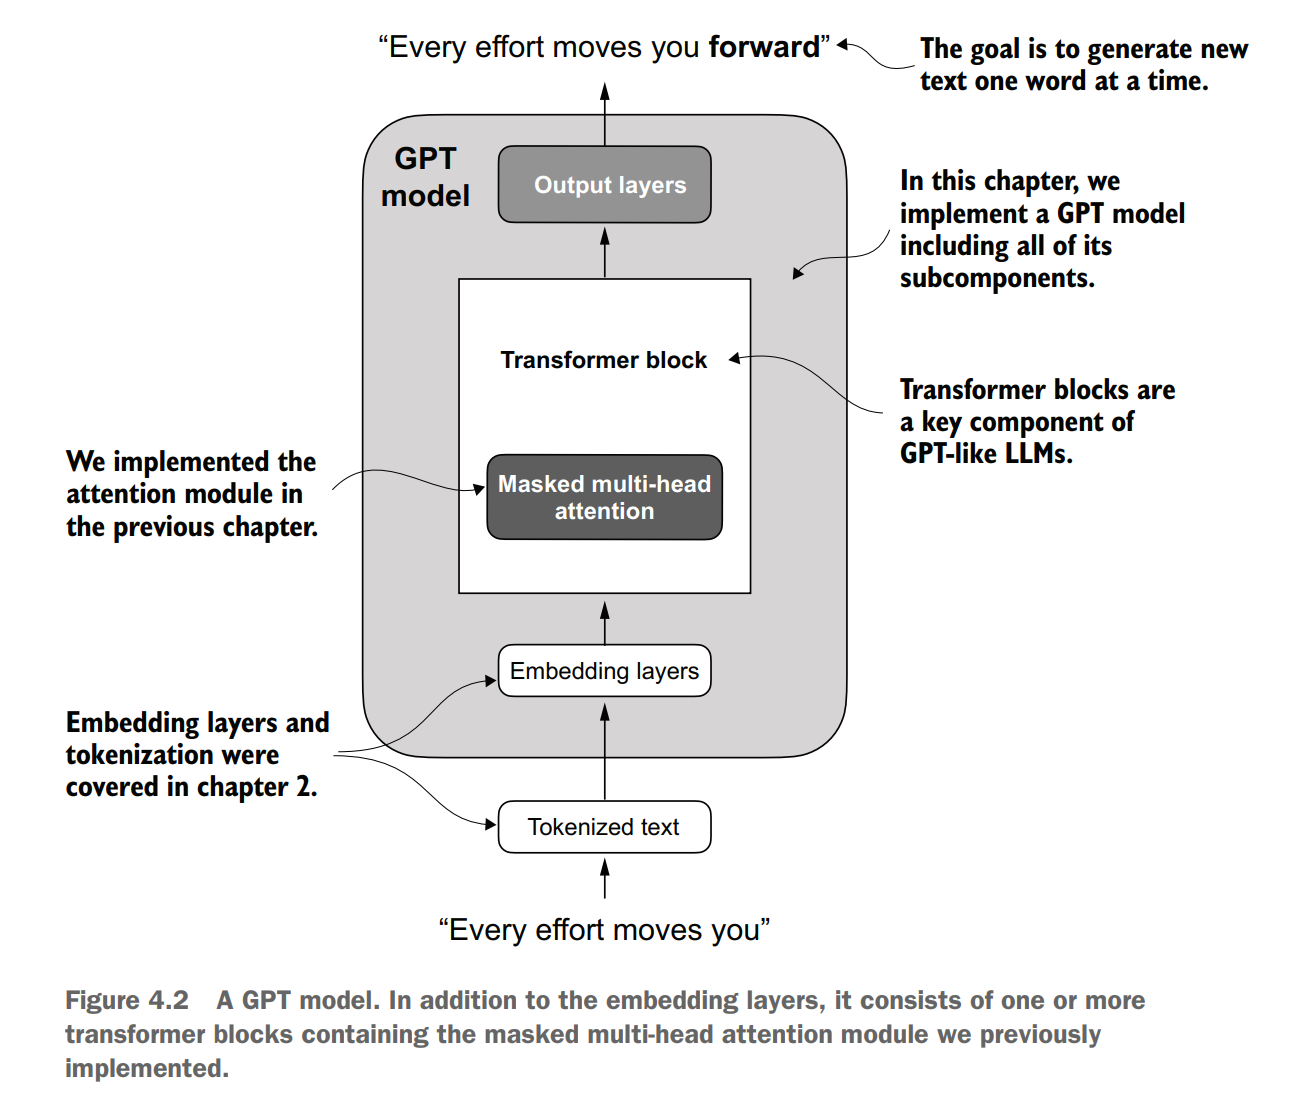



The GPT-$2$ model processes input text as follows:

1. Tokenization: Outside the GPT-$2$ model, raw text is tokenized into token IDs using a library like tiktoken, which implements Byte Pair Encoding (BPE). Each token ID corresponds to a unique token in the vocabulary.
2. Token Embeddings: The GPT-$2$ model takes these token IDs as input and maps them to dense vectors using a trainable token embedding matrix of shape `(vocabulary_size, embedding_dim)`. For a given token ID, the corresponding row of the matrix is selected to produce an embedding vector.

    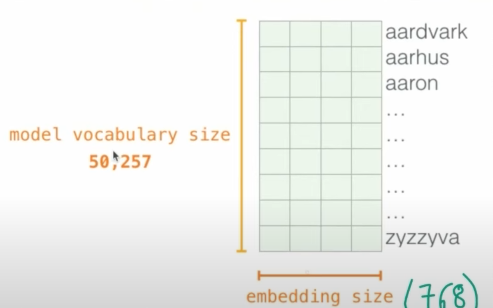

3. Positional Embeddings: To encode the position of each token in the sequence, GPT-$2$ uses a trainable positional embedding matrix of shape  `(max_context_length, embedding_dim)`, 
where max_context_length is the maximum sequence length (e.g., $1024$). For each position $i$ (from $0$ to sequence length $-1$), a unique positional embedding vector is retrieved from this matrix.

    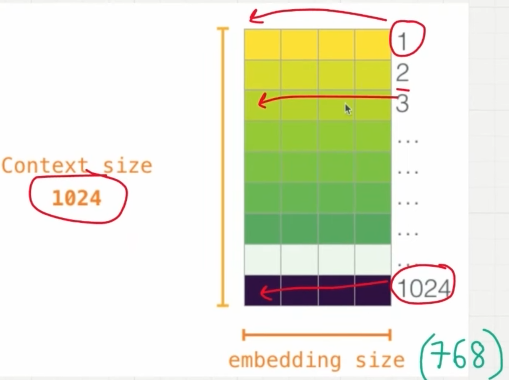
    
4. Combining Embeddings: The token embedding and positional embedding for each token are added element-wise to produce a combined embedding of shape (embedding_dim,). For a sequence of length $T$, the input to the transformer is a matrix of shape ($T$, embedding_dim).

5. Dropouts for regularization

6. Transformer: The transformer in GPT-2 consists of multiple decoder-only blocks, each containing a masked multi-head self-attention layer followed by a feed-forward layer, with layer normalization and residual connections.

7. Layer Normalization: Applied in each transformer block to stabilize training and improve convergence.

8. Feed forward layer: The final output layer (after all transformer blocks) is a linear layer that maps the transformer’s output shape `(batch_size, seq_len, embed_dim)` to logits over the vocabulary shape `(batch_size, seq_len, vocab_size)`. These logits are used to compute probabilities (e.g., via softmax) for predicting the next token.
    

We specify the configuration of the small GPT-2 model via the following Python dictionary:

In [2]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

1. `vocab_size` refers to a vocabulary of 50,257 words, as used by the BPE tokenizer
2. `context_length` denotes the maximum number of input tokens the model can
handle via the positional embeddings.
3. `emb_dim` represents the embedding size, transforming each token into a 768-
dimensional vector.
4. `n_heads` indicates the count of attention heads in the multi-head attention
mechanism.
5. `n_layers` specifies the number of transformer blocks in the model.
6. `drop_rate` indicates the intensity of the dropout mechanism to prevent overfitting.
7. `qkv_bias` determines whether to include a bias vector in the Linear layers of
the multi-head attention for query, key, and value computations. We will initially
disable this, following the norms of modern LLMs, but we will revisit it in chapter 6 when we load pretrained GPT-2 weights from OpenAI into our model.

In [ ]:
class DummyGPTModel(nn.Module):
    
    def __init__(self, config):

        super().__init__()

        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        # for gpt - 2 small, vocab_size = 50257 and emb_dim = 768
        # This matrix is also called lookup table we pass in the token id and get the corresponding embedding
        # Also a trainable parameter

        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])

        self.drop_emb = nn.Dropout(config["drop_rate"])



        # The following is a placeholder for the transformer blocks
        # This is a sequential container that contains n_layers transformer blocks
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(config) for _ in range(config["n_layers"])]
        )
        ''' The * unpacks the list so that nn.Sequential receives block1, block2, block3 as separate arguments, matching its expected input.'''
        # Placeholder for the LayerNorm
        self.final_norm = DummyLayerNorm(config["emb_dim"])
        
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)




    def forward(self, in_idx):
        # in_idx is the input token ids
        batch_size, seq_len = in_idx.shape
        
        # What we are doing here is looking up the token ids in token embedding matrix created in the constructor 
        # to get the 768 embedding vectors for each token id of the input sequence
        # So, if one batch has 4 tokens, for each batch we will get 4 embedding vectors of size 768
        tok_embeds = self.tok_emb(in_idx) 
        ''' For each token ID, nn.Embedding retrieves a vector of shape (emb_dim,), so tok_embeds has shape (batch_size, seq_len, emb_dim).'''


        # We are creating a position embedding matrix of size (seq_len, emb_dim)
        # What arange is doing is creating a tensor of size (seq_len) with values from 0 to seq_len - 1
        # And then we are passing this tensor to position embedding to get only that many position embeddings
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        '''
        pos_embeds is not the entire positional embedding matrix. It’s a tensor of shape (seq_len, emb_dim) containing only the embeddings for the positions [0, 1, ..., seq_len-1]. Only seq_len rows of the (context_length, emb_dim) matrix are used.
        '''
        # We are adding the token embeddings and position embeddings (both 768 dimensional vectors)
        # This is the final embedding matrix we will pass to the transformer
        x = tok_embeds + pos_embeds

        '''
        Here, pos_embeds (shape (seq_len, emb_dim)) is broadcasted to match tok_embeds (shape (batch_size, seq_len, emb_dim)).
        Broadcasting replicates pos_embeds across the batch_size dimension, effectively treating it as (batch_size, seq_len, emb_dim) for the addition.

        The result x has shape (batch_size, seq_len, emb_dim).
        '''

        # We are applying dropout to the embedding matrix which is a regularization technique
        x = self.drop_emb(x)

        x = self.trf_blocks(x)  # (batch_size, seq_len, emb_dim)
        
        x = self.final_norm(x)  # (batch_size, seq_len, emb_dim)

        logits = self.out_head(x)
        # This will output a tensor of shape (batch_size, seq_len, vocab_size)
        return logits


In [8]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Placeholder for the transformer block 
    
    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module): 
    def __init__(self, normalized_shape, eps=1e-5): 
        super().__init__()
 
    def forward(self, x):
        return x

### Tokenize

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)
# 4 token ids for the first and second sentences (batches here)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### Use the instance of DummyGPT model

In [10]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


The probabilities of the output are random obviously( no transformer and layer norm blocks as well as no training done)

We should visualize the workflow of above cell's code as follows

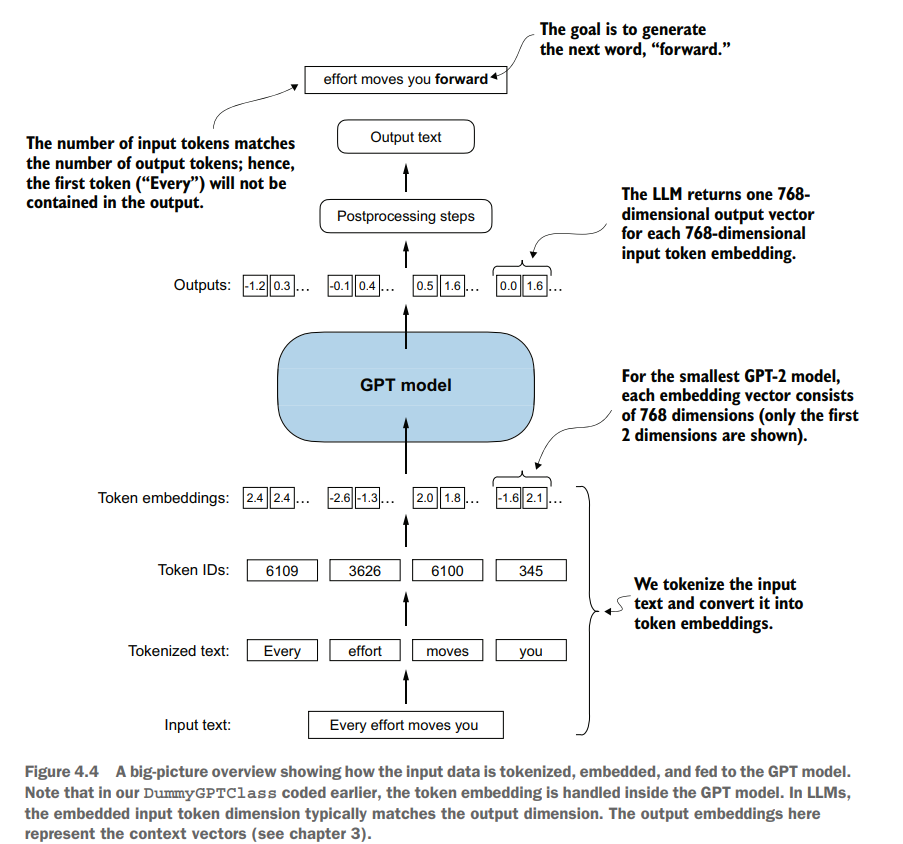

When we implement the postprocessing code, we
will convert these $50,257$-dimensional vectors back into token IDs, which we can then
decode into words